# Synthetic Data Comparison

In this notebook, different ways to compare the quality of augmented time series are explored.

## Imports and static variables

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_absolute_error

# own classes
from utilities import load_sequential_time_series, reconstruct_sequential_data, load_complete_time_series, slice_years, train_test_split, extract_features_and_targets, split_data_into_sequences, Scaler, ValidationLossAccumulationCallback
from baseline_model.LSTM import LSTM, train_model
from baseline_model.TimeSeriesDataset import TimeSeriesDataset
from baseline_model.mean_regressor import MeanRegressor

In [2]:
DATA_FOLDER = Path("./data")
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"
REAL_DATA_FOLDER = DATA_FOLDER / "real"

In [3]:
MODEL = 'lstm'
FEATURES = ['Close', 'Volume']


LEARNING_RATE = 0.001 if MODEL == 'lstm' else 0.0001
FIRST_SPLIT = 0.97 if 'Close' in FEATURES else 0.8
SECOND_SPLIT = 0.5 if 'Close' in FEATURES else 0.5

SEQ_LEN = 14
BATCH_SIZE = 32
HIDDEN_SIZE = 12
NUM_LAYERS = 1

NUM_EPOCHS = 1000

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Loading data

In [5]:
aapl = load_complete_time_series(REAL_DATA_FOLDER / "AAPL_complete.csv")

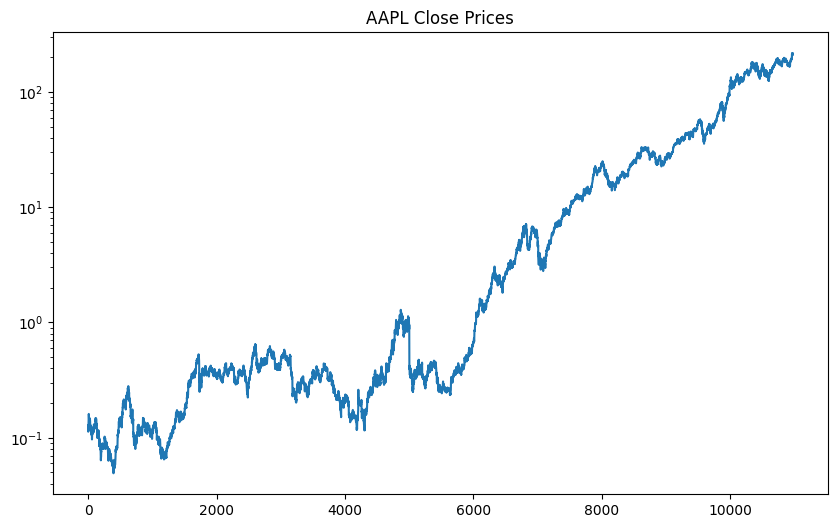

In [6]:
# plot log of close prices
plt.figure(figsize=(10, 6))
plt.plot(aapl['Close'])
plt.yscale('log')
plt.title('AAPL Close Prices')
plt.show()

In [7]:
# get normal difference
# aapl['Daily Returns'] = aapl['Close'].diff()

# get percaentage difference
aapl['Daily Returns'] = aapl['Close'].pct_change()

In [8]:
# set trend to 1 if daily return > 1, else -1
aapl['Trend'] = aapl['Daily Returns'].apply(lambda x: 1 if x > 0 else 0)

In [9]:
aapl = aapl.dropna()
aapl = aapl[FEATURES]

In [10]:
aapl.head()

,Close,Volume
1,0.121652,175884800
2,0.112723,105728000
3,0.115513,86441600
4,0.118862,73449600
5,0.126116,48630400


In [11]:
aapl.describe()

,Close,Volume
count,10977.000000,1.097700e+04
mean,21.945268,3.185514e+08
std,45.258622,3.355775e+08
min,0.049107,0.000000e+00
25%,0.297991,1.135456e+08
50%,0.527902,2.060464e+08
75%,20.010000,3.989468e+08
max,216.750000,7.421641e+09


In [12]:
aapl_np = aapl.to_numpy()

In [13]:
aapl_train, aapl_test = train_test_split(aapl_np, FIRST_SPLIT)
aapl_test, aapl_val = train_test_split(aapl_test, SECOND_SPLIT)

In [14]:
aapl_test[SEQ_LEN:SEQ_LEN+2]

array([[1.60770004e+02, 5.13057000e+07],
       [1.62360001e+02, 4.95017000e+07]])

In [15]:
aapl_test_dummy = split_data_into_sequences(aapl_test, SEQ_LEN)

Shape of the data after splitting into sequences: (152, 14, 2)


In [16]:
scaler = Scaler(aapl_train)

In [17]:
aapl_train_scaled = scaler.scale_data(aapl_train)
aapl_test_scaled = scaler.scale_data(aapl_test)
aapl_val_scaled = scaler.scale_data(aapl_val)

In [18]:
aapl_test_scaled[:10]

array([[0.82732553, 0.0072536 ],
       [0.81583957, 0.00923952],
       [0.82666608, 0.01137984],
       [0.83831691, 0.00992987],
       [0.84051523, 0.01039769],
       [0.8562329 , 0.01026203],
       [0.85156153, 0.0133319 ],
       [0.86475115, 0.00992252],
       [0.87508307, 0.00996253],
       [0.86711434, 0.01020014]])

In [19]:
aapl_train_seq_scaled = split_data_into_sequences(aapl_train_scaled, SEQ_LEN)
aapl_test_seq_scaled = split_data_into_sequences(aapl_test_scaled, SEQ_LEN)
aapl_val_seq_scaled = split_data_into_sequences(aapl_val_scaled, SEQ_LEN)

Shape of the data after splitting into sequences: (10634, 14, 2)
Shape of the data after splitting into sequences: (152, 14, 2)
Shape of the data after splitting into sequences: (152, 14, 2)


In [20]:
aapl_train_seq_scaled.shape

(10634, 14, 2)

In [21]:
X_train, y_train, X_test, y_test, X_val, y_val = extract_features_and_targets(aapl_train_seq_scaled, aapl_test_seq_scaled, aapl_val_seq_scaled)

In [22]:
scaler.inverse_scale_data(y_train[200].cpu().numpy(), feature_type='price')

array([0.083147])

In [23]:
y_test[0]

tensor([0.8661])

In [24]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)
val_dataset = TimeSeriesDataset(X_val, y_val)

In [25]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [26]:
criterion = nn.MSELoss()
criterion_absolute = nn.L1Loss()
criterion_binary = nn.BCELoss()

In [27]:
losses = []
validation_loss_accumulation_callback = ValidationLossAccumulationCallback(losses)

In [28]:
if MODEL == 'lstm':

    model = LSTM(
        device=device,
        input_size=X_train.shape[2], # number of features
        hidden_size=HIDDEN_SIZE,
        num_stacked_layers=NUM_LAYERS
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    losses, model = train_model(model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        criterion=criterion_absolute,
                        optimizer=optimizer,
                        device=device)
    
elif MODEL == 'xgb':

    model = XGBClassifier(
        objective='multi:softprob',
        num_class=2,      
        max_depth=10,       
        learning_rate=0.001,
        n_estimators=1000
    )
    
    # model = XGBRegressor(
    #     n_estimators=10000,
    #     max_depth=10,
    #     learning_rate=0.001,
    #     subsample=0.8,
    #     objective='reg:squarederror',
    #     early_stopping_rounds=10, 
    #     eval_metric=mean_absolute_error,
    #     callbacks=[validation_loss_accumulation_callback], 
    #     verbosity=2,
    #     random_state=69,
    #     device=device
    # )
    model.fit(
        X_train.reshape((X_train.shape[0], -1)), 
        y_train,
        eval_set=[(X_val.reshape((X_val.shape[0], -1)), y_val)]
    )

Epoch: 1
Validation Loss: 0.06255609095096588
**************************************************
Epoch: 2
Validation Loss: 0.05914288833737373
**************************************************
Epoch: 3
Validation Loss: 0.04620875269174576
**************************************************
Epoch: 4
Validation Loss: 0.09770444631576539
INFO: Validation loss did not improve in epoch 4
**************************************************
Epoch: 5
Validation Loss: 0.05875236690044403
INFO: Validation loss did not improve in epoch 5
**************************************************
Epoch: 6
Validation Loss: 0.08449053466320038
INFO: Validation loss did not improve in epoch 6
**************************************************
Epoch: 7
Validation Loss: 0.07981634587049484
INFO: Validation loss did not improve in epoch 7
**************************************************
Epoch: 8
Validation Loss: 0.07801742106676102
INFO: Validation loss did not improve in epoch 8
******************************

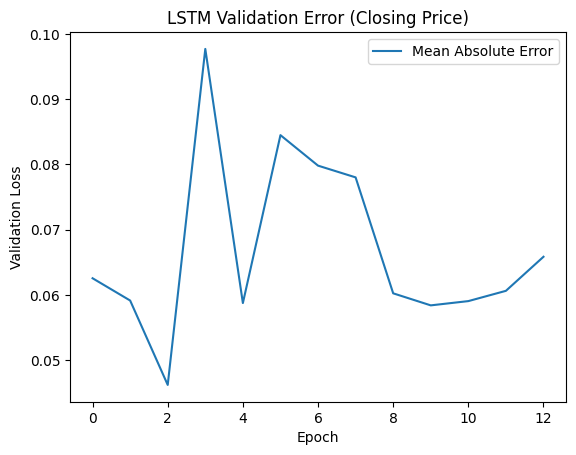

In [29]:
# plot validation loss
plt.title(f'{"LSTM" if MODEL == "lstm" else "XGBRegressor"} Validation Error ({"Closing Price" if "Close" in FEATURES else "Daily Returns"})')
plt.plot(losses, label="Mean Absolute Error")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.legend()
plt.show()

## Evaluation

In [30]:
if MODEL == 'lstm':

    with torch.inference_mode(): 
        test_pred = model(X_test.to(device)).to('cpu').detach().numpy()
        train_pred = model(X_train.to(device)).to('cpu').detach().numpy()

elif MODEL == 'xgb':
        
    test_pred = model.predict(X_test.reshape((X_test.shape[0], -1)))
    train_pred = model.predict(X_train.reshape((X_train.shape[0], -1)))

In [31]:
test_pred = scaler.inverse_scale_data(test_pred, feature_type='price')
train_pred = scaler.inverse_scale_data(train_pred, feature_type='price')
y_test = scaler.inverse_scale_data(y_test.cpu().numpy(), feature_type='price')
y_train = scaler.inverse_scale_data(y_train.cpu().numpy(), feature_type='price')

In [32]:
# mean absolute error of only zeros
loss = criterion_absolute(torch.zeros_like(torch.tensor(y_test)), torch.tensor(y_test)).item()
loss

177.75717180631057

In [33]:
test_range = (0, 50)
train_range = (0, len(y_train))

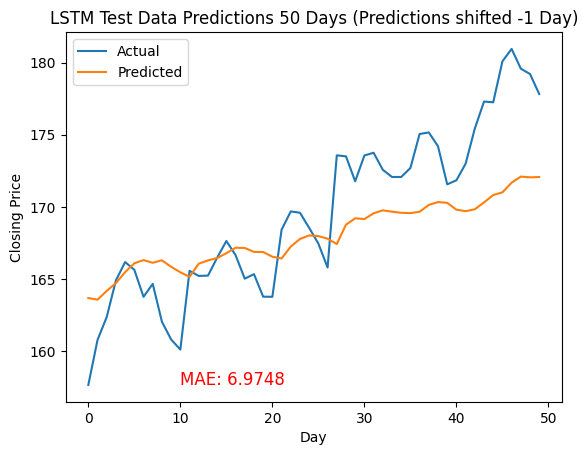

In [34]:
# mean absolute error of test data predictions
loss = criterion_absolute(torch.tensor(test_pred), torch.tensor(y_test)).item()
loss

# plot test data
plt.title(f'{"LSTM" if MODEL == "lstm" else "XGBRegressor"} Test Data Predictions {test_range[1]-test_range[0]} Days (Predictions shifted -1 Day)')
plt.plot(y_test[test_range[0]: test_range[1]], label="Actual")
plt.plot(np.roll(test_pred[test_range[0]: test_range[1]], 0), label="Predicted")
plt.xlabel("Day")
plt.ylabel(f'{"Daily Return" if "Daily Returns" in FEATURES else "Closing Price"}')
plt.text(10, min(y_test[test_range[0]: test_range[1]]), f'MAE: {loss:.4f}', fontsize=12, color='red')
plt.legend()
plt.show()

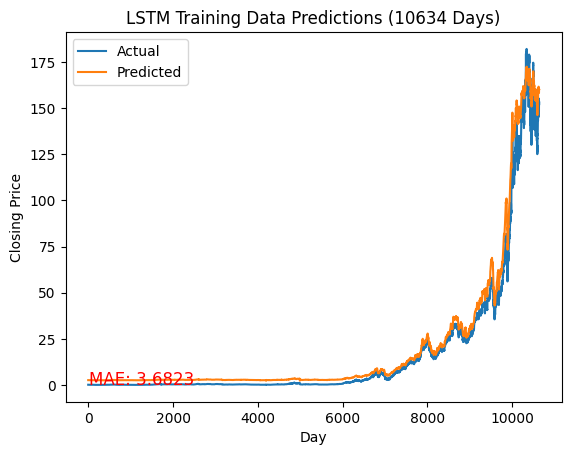

In [35]:
# mean absolute error of training data predictions
loss = criterion_absolute(torch.tensor(train_pred), torch.tensor(y_train)).item()
loss

# plot train data
plt.title(f'{"LSTM" if MODEL == "lstm" else "XGBRegressor"} Training Data Predictions ({train_range[1]-train_range[0]} Days)')
plt.plot(y_train[train_range[0]: train_range[1]], label="Actual")
plt.plot(train_pred[train_range[0]: train_range[1]], label="Predicted")
plt.xlabel("Day")
plt.ylabel(f'{"Daily Return" if "Daily Returns" in FEATURES else "Closing Price"}')
plt.legend()
plt.text(10, min(y_train[train_range[0]: train_range[1]]), f'MAE: {loss:.4f}', fontsize=12, color='red')
plt.show()

In [36]:
y_train[7000]

4.059286060611576

### dummy testing

In [37]:
dummy = MeanRegressor()

In [38]:
dummy_preds = dummy.make_predictions(aapl_test_dummy, returns=True if 'Daily Returns' in FEATURES else False)

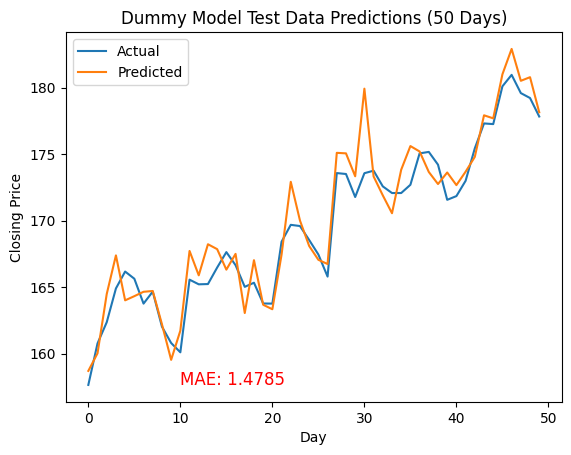

In [39]:
loss = criterion_absolute(torch.tensor(dummy_preds), torch.tensor(y_test)).item()
loss

# plot train data
plt.title(f'Dummy Model Test Data Predictions ({test_range[1]-test_range[0]} Days)')
plt.plot(y_test[test_range[0]: test_range[1]], label="Actual")
plt.plot(dummy_preds[test_range[0]: test_range[1]], label="Predicted")
plt.xlabel("Day")
plt.ylabel(f'{"Daily Return" if "Daily Returns" in FEATURES else "Closing Price"}')
plt.legend()
plt.text(10, min(y_test[test_range[0]: test_range[1]]), f'MAE: {loss:.4f}', fontsize=12, color='red')
plt.show()

## MAE and MSE Loss experiments

In [41]:
# real = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# A = np.array([1, 2, 3, 4, 5, 6, 8, 9, 10, 12])
# B = np.array([1, 2.1, 3.1, 4.1, 5.1, 6, 7, 8, 9, 10])

# # scale
# scaler = MinMaxScaler(feature_range=(0, 1))
# real_scaled = scaler.fit_transform(real.reshape(-1, 1))
# A_scaled = scaler.fit_transform(A.reshape(-1, 1))
# B_scaled = scaler.fit_transform(B.reshape(-1, 1))

# loss_MSE = torch.nn.MSELoss()
# loss_MAE = torch.nn.L1Loss()

# MSE_A = loss_MSE(torch.tensor(real_scaled, dtype=torch.float32), torch.tensor(A_scaled, dtype=torch.float32))
# MAE_A = loss_MAE(torch.tensor(real, dtype=torch.float32), torch.tensor(A, dtype=torch.float32))
# MSE_B = loss_MSE(torch.tensor(real_scaled, dtype=torch.float32), torch.tensor(B_scaled, dtype=torch.float32))
# MAE_B = loss_MAE(torch.tensor(real, dtype=torch.float32), torch.tensor(B, dtype=torch.float32))

# print(f'MSE_A: {MSE_A}\n')
# print(f'MAE_A: {MAE_A}\n')
# print(f'MSE_B: {MSE_B}\n')
# print(f'MAE_B: {MAE_B}\n')